✅ Processing 2500 images
Feature matrix shape: (2496, 1176)
After PCA: (2496, 200)
Accuracy: 0.688

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70       256
           1       0.68      0.67      0.68       244

    accuracy                           0.69       500
   macro avg       0.69      0.69      0.69       500
weighted avg       0.69      0.69      0.69       500

Confusion Matrix:
 [[181  75]
 [ 81 163]]


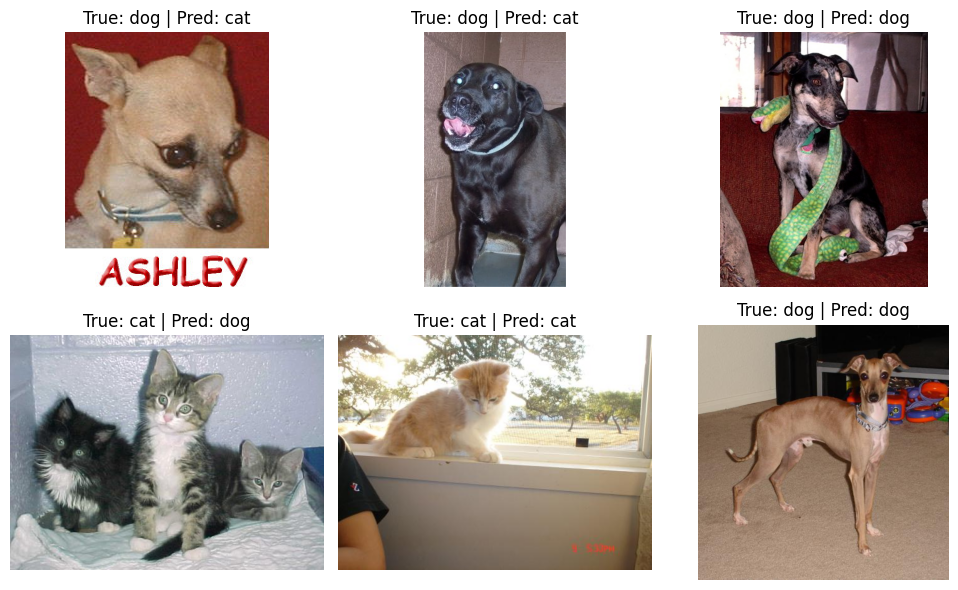

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import Parallel, delayed
import matplotlib.pyplot as plt


IMG_SIZE = (64, 64)
HOG_PARAMS = dict(pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=6)
SAMPLE_FRAC = 0.1  # 10% sample for faster prototyping
PCA_COMPONENTS = 200
N_JOBS = -1 

df = pd.read_csv('labels.csv')
df = df.sample(frac=SAMPLE_FRAC, random_state=42).reset_index(drop=True)
print("✅ Processing", len(df), "images")


def extract_hog(row):
    label = row['label']
    path = os.path.join('PetImages', label.capitalize(), row['filename'])
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, IMG_SIZE)
    fd = hog(img, **HOG_PARAMS) 
    return fd, (0 if label == 'cat' else 1)


results = Parallel(n_jobs=N_JOBS)(
    delayed(extract_hog)(row) for _, row in df.iterrows()
)
filtered = [r for r in results if r is not None]
X, y = zip(*filtered)
X = np.array(X)
y = np.array(y)
print("Feature matrix shape:", X.shape)

pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
X_reduced = pca.fit_transform(X)
print("After PCA:", X_reduced.shape)


X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)
clf = SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
sample_idxs = np.random.choice(len(X_test), 6, replace=False)
for ax, idx in zip(axes.flatten(), sample_idxs):
    row = df.iloc[idx]
    img = cv2.imread(os.path.join('PetImages', row['label'].capitalize(), row['filename']))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"True: {row['label']} | Pred: {'cat' if y_pred[idx]==0 else 'dog'}")
    ax.axis('off')
plt.tight_layout()
plt.show()
